<a href="https://colab.research.google.com/github/joekibz/moringa-wk10/blob/main/Telco_Customer_Churn_Pyspark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project Brief: Telecom Customer Churn Prediction using PySpark

<h3><b>Background Information</b></h3>
Customer churn is a significant challenge in the telecom industry. Identifying customers who are
likely to churn is crucial for implementing proactive measures to retain them. By leveraging PySpark,
we can take advantage of its distributed computing capabilities to handle large volumes of data
efficiently and build an accurate machine learning model for churn prediction.


## Problem Statement

The goal of this project is to develop a machine learning model using PySpark that <b><i>accurately
predicts customer churn in a telecom company. The model should achieve a minimum accuracy of
0.8,</i></b> enabling the company to proactively identify and retain customers at risk of leaving. By
effectively predicting churn, the company can implement targeted retention strategies, reduce
customer attrition, and improve overall business performance.

## Solution Steps

In [1]:
#install pyspark
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.0-py2.py3-none-any.whl size=311317130 sha256=8a149a1cf48e56400656635f3fe07a9e2fda7a04c7b33e5d5e50fb9a8d927c28
  Stored in directory: /root/.cache/pip/wheels/7b/1b/4b/3363a1d04368e7ff0d408e57ff57966fcdf00583774e761327
Successfully built pyspark


In [2]:
## Import the libraries
from pyspark.sql.session import SparkSession
from pyspark import SparkContext
import os
import urllib.request
from pyspark.sql.functions import col
import matplotlib.pyplot as plt
import pyspark.sql.functions as F

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, DecisionTreeClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator,MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.feature import VectorAssembler, StringIndexer, StandardScaler, MinMaxScaler


In [3]:
# Create a SparkSession
spark = SparkSession.builder.appName("Churn101").getOrCreate()

# Local file path to save the downloaded CSV file
local_file_path = os.getcwd() + "/telecom_dataset.csv"

#Dataset URL
csv_url = "https://archive.org/download/telecom_dataset/telecom_dataset.csv"



In [4]:
# Download the CSV file
urllib.request.urlretrieve(csv_url, local_file_path)

# Fetch and load dataset: https://archive.org/download/telecom_dataset/telecom_dataset.csv
df = spark.read.csv(local_file_path, header=True)



### Initial Data Exploration

In [5]:
#Preview df data 
df.show()

+----------+------+---+--------------+--------------+------------+-----+
|CustomerID|Gender|Age|      Contract|MonthlyCharges|TotalCharges|Churn|
+----------+------+---+--------------+--------------+------------+-----+
|         1|Female| 25|Month-to-Month|          65.7|       156.5|   No|
|         2|  Male| 37|      One Year|          89.0|      2356.8|   No|
|         3|  Male| 52|      Two Year|         115.5|      5408.6|   No|
|         4|Female| 30|Month-to-Month|          75.9|       129.4|  Yes|
|         5|  Male| 45|      One Year|          98.2|      3142.0|   No|
|         6|Female| 55|      Two Year|          99.9|      6541.5|   No|
|         7|  Male| 32|Month-to-Month|          82.1|       267.7|  Yes|
|         8|Female| 28|Month-to-Month|          61.5|       346.9|   No|
|         9|  Male| 48|      One Year|         101.8|      5149.6|  Yes|
|        10|Female| 60|      Two Year|         108.1|      6742.8|  Yes|
|        11|  Male| 42|Month-to-Month|          78.

In [6]:
#Check df shape
# Number of columns
num_columns = len(df.columns)
print("Number of columns:", num_columns)

# Number of rows
num_rows = df.count()
print("Number of rows:", num_rows)

Number of columns: 7
Number of rows: 20


In [7]:
#View df schema
df.printSchema()

root
 |-- CustomerID: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Age: string (nullable = true)
 |-- Contract: string (nullable = true)
 |-- MonthlyCharges: string (nullable = true)
 |-- TotalCharges: string (nullable = true)
 |-- Churn: string (nullable = true)



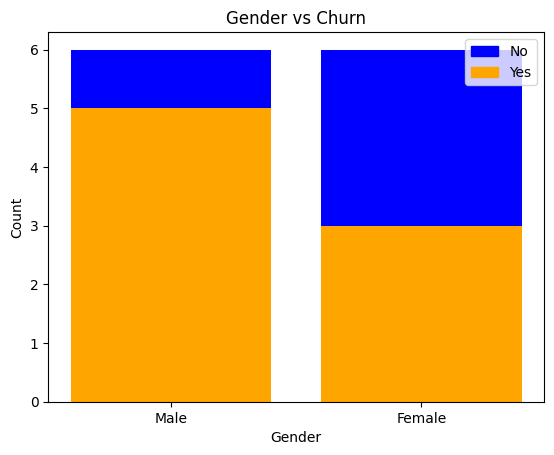

In [8]:
#Do some aggregations ...
#Explore Gender vs Churn stats
# Group the data by Gender and Churn and count the occurrences
gender_churn_counts = df.groupby('Gender', 'Churn').count().toPandas()

# Define the colors for "No" and "Yes"
colors = ['blue', 'orange']

# Plot the bar chart
plt.bar(gender_churn_counts['Gender'], gender_churn_counts['count'], color=['blue', 'orange'])

# Add labels and title
plt.xlabel('Gender')
plt.ylabel('Count')
plt.title('Gender vs Churn')

# Create a legend
legend_labels = ['No', 'Yes']
legend_patches = [plt.Rectangle((0, 0), 1, 1, color=color) for color in colors]
plt.legend(legend_patches, legend_labels)

# Display the chart
plt.show()

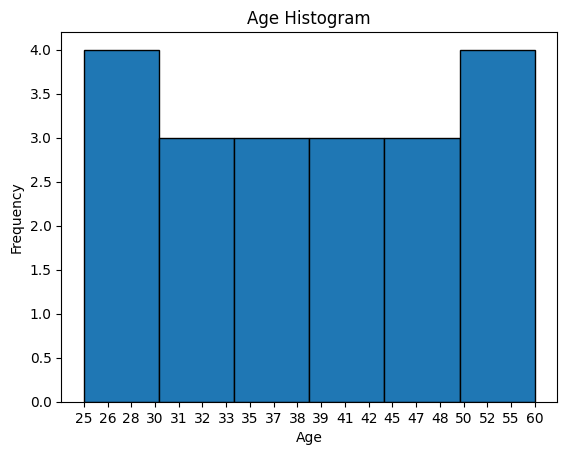

In [9]:
#Explore Age feature
# Extract the Age column as a list
age_values = df.select('Age').rdd.flatMap(lambda x: x).collect()

# Sort the age values in ascending order
age_values.sort()

# Plot the histogram
plt.hist(age_values, bins='auto', edgecolor='black')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Age Histogram')
plt.show()



### Data Preprocessing

In [10]:
#Drop nulls 
# Drop null rows
df = df.na.drop()

# Verify the result
print("Shape of DataFrame: {} rows, {} columns".format(df.count(), len(df.columns)))

Shape of DataFrame: 20 rows, 7 columns


In [11]:
#Drop duplicate row entries
df = df.dropDuplicates()

# Verify the result
print("Shape of DataFrame: {} rows, {} columns".format(df.count(), len(df.columns)))

Shape of DataFrame: 20 rows, 7 columns


In [12]:
#Cast numeric columns from string type to integer or float
# Convert Age column to integer type
updated_df = df.withColumn("Age", col("Age").cast("integer"))

# Convert MonthlyCharges column to float type
updated_df = updated_df.withColumn("MonthlyCharges", col("MonthlyCharges").cast("float"))

# Convert TotalCharges column to float type
updated_df = updated_df.withColumn("TotalCharges", col("TotalCharges").cast("float"))

#View updated schema
updated_df.printSchema()

root
 |-- CustomerID: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Contract: string (nullable = true)
 |-- MonthlyCharges: float (nullable = true)
 |-- TotalCharges: float (nullable = true)
 |-- Churn: string (nullable = true)



### Feature Engineering 

In [13]:
#Add Age_group column

# Create a new column 'Age_group' based on 'Age' column
df_with_age_group = updated_df.withColumn(
    'Age_group',
    F.when((F.col('Age') >= 0) & (F.col('Age') < 5), '0-4')
    .when((F.col('Age') >= 5) & (F.col('Age') < 10), '5-9')
    .when((F.col('Age') >= 10) & (F.col('Age') < 15), '10-14')
    .when((F.col('Age') >= 15) & (F.col('Age') < 20), '15-19')
    .when((F.col('Age') >= 20) & (F.col('Age') < 25), '20-24')
    .when((F.col('Age') >= 25) & (F.col('Age') < 30), '25-29')
    .when((F.col('Age') >= 30) & (F.col('Age') < 35), '30-34')
    .when((F.col('Age') >= 35) & (F.col('Age') < 40), '35-39')
    .when((F.col('Age') >= 40) & (F.col('Age') < 45), '40-44')
    .when((F.col('Age') >= 45) & (F.col('Age') < 50), '45-49')
    .when((F.col('Age') >= 50) & (F.col('Age') < 55), '50-54')
    .when((F.col('Age') >= 55) & (F.col('Age') < 60), '55-59')
    .when((F.col('Age') >= 60) & (F.col('Age') < 65), '60-64')
    .otherwise('65+')
)

# Show the updated DataFrame
df_with_age_group.show()


+----------+------+---+--------------+--------------+------------+-----+---------+
|CustomerID|Gender|Age|      Contract|MonthlyCharges|TotalCharges|Churn|Age_group|
+----------+------+---+--------------+--------------+------------+-----+---------+
|        16|  Male| 47|      Two Year|         112.3|      5432.0|  Yes|    45-49|
|        20|  Male| 39|      Two Year|          97.1|      3992.4|   No|    35-39|
|        17|Female| 26|Month-to-Month|          68.2|       289.1|   No|    25-29|
|        11|  Male| 42|Month-to-Month|          78.9|       547.6|   No|    40-44|
|        18|  Male| 33|Month-to-Month|          75.5|       462.5|  Yes|    30-34|
|         7|  Male| 32|Month-to-Month|          82.1|       267.7|  Yes|    30-34|
|         4|Female| 30|Month-to-Month|          75.9|       129.4|  Yes|    30-34|
|         8|Female| 28|Month-to-Month|          61.5|       346.9|   No|    25-29|
|        10|Female| 60|      Two Year|         108.1|      6742.8|  Yes|    60-64|
|   

In [14]:
# Add a new column 'Month_Total_Ratio' by dividing 'MonthlyCharges' / 'TotalCharges'
df_with_ratio = df_with_age_group.withColumn(
    'Month_Total_Ratio',
    F.col('MonthlyCharges') / F.col('TotalCharges')
)

# Show the updated DataFrame
df_with_ratio.show()

+----------+------+---+--------------+--------------+------------+-----+---------+--------------------+
|CustomerID|Gender|Age|      Contract|MonthlyCharges|TotalCharges|Churn|Age_group|   Month_Total_Ratio|
+----------+------+---+--------------+--------------+------------+-----+---------+--------------------+
|        16|  Male| 47|      Two Year|         112.3|      5432.0|  Yes|    45-49|0.020673785539719772|
|        20|  Male| 39|      Two Year|          97.1|      3992.4|   No|    35-39|0.024321210512283167|
|        17|Female| 26|Month-to-Month|          68.2|       289.1|   No|    25-29| 0.23590451576753818|
|        11|  Male| 42|Month-to-Month|          78.9|       547.6|   No|    40-44|  0.1440832816719086|
|        18|  Male| 33|Month-to-Month|          75.5|       462.5|  Yes|    30-34| 0.16324324324324324|
|         7|  Male| 32|Month-to-Month|          82.1|       267.7|  Yes|    30-34| 0.30668656978105546|
|         4|Female| 30|Month-to-Month|          75.9|       129.

In [15]:
# Feature Scaling 
# Define the numerical columns
numerical_columns = ['Age', 'MonthlyCharges', 'TotalCharges', 'Month_Total_Ratio']

# Assemble the numerical columns into a vector column
assembler = VectorAssembler(inputCols=numerical_columns, outputCol="vFeatures")

# Create a MinMaxScaler object
scaler = MinMaxScaler(inputCol="vFeatures", outputCol="scaled_features")


In [16]:
#Categorical encoding

catCols = ['Gender', 'Contract', 'Churn', 'Age_group']
indexers = []

# Iterate over the categorical columns
for col in catCols:
    # Create a StringIndexer object, and specify the input and output columns
    stringindexer = StringIndexer(inputCol=col, outputCol=col+"_index")
    indexers.append(stringindexer)

# Create a Pipeline to chain the StringIndexer stages
#-pipeline = Pipeline(stages=indexers)
pipeline = Pipeline(stages=[assembler, scaler] + indexers)

pipeline_model = pipeline.fit(df_with_ratio)
df_encoded = pipeline_model.transform(df_with_ratio)



### Model Selection and Training

In [17]:
#Feature and Label Target selection

feature_columns = ["scaled_features", "Gender_index", "Contract_index", "Age_group_index"]
label_column = "Churn_index"

# Vectorize Features
vectorAssembler = VectorAssembler(inputCols=feature_columns, outputCol="mainFeatures")
v_data = vectorAssembler.transform(df_encoded)

#Drop columns which are no longer needed
columns_to_drop = ["CustomerID", "Gender", "Age", "Contract", "MonthlyCharges", "TotalCharges", "Churn", "Age_group", "Month_Total_Ratio", "vFeatures", "scaled_features", "Gender_index", "Contract_index", "Age_group_index"]
v_data = v_data.drop(*columns_to_drop)

# Split the Data for Training and Testing
splits = v_data.randomSplit([0.8, 0.2], seed=42)
train_data = splits[0]
test_data = splits[1]

# Verify the result
#train_data.show(truncate=False)
print("Size of Training DataFrame: {} rows".format(train_data.count()))
print("Size of Testing DataFrame: {} rows".format(test_data.count()))
train_data.printSchema()


Size of Training DataFrame: 15 rows
Size of Testing DataFrame: 5 rows
root
 |-- Churn_index: double (nullable = false)
 |-- mainFeatures: vector (nullable = true)



In [18]:
# Model Selection and Training
lr = LogisticRegression(labelCol="Churn_index", featuresCol="mainFeatures")

# Create a ParamGrid for grid search
param_grid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.01, 0.1, 1.0]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
    .build()
		   
# Define the evaluator
evaluator = BinaryClassificationEvaluator(labelCol="Churn_index")

# Create CrossValidator with the LogisticRegression model and BinaryClassificationEvaluator
cross_validator = CrossValidator(estimator=lr,estimatorParamMaps=param_grid,evaluator=evaluator,numFolds=2)  

# Fit the cross-validator to the training data
cvModel = cross_validator.fit(train_data)

# Evaluate the model using the evaluator
accuracy = evaluator.evaluate(cvModel.transform(test_data))

# Get the best model
best_model = cvModel.bestModel



### Model Evaluation

In [19]:
# Print the best parameters
best_params = best_model.extractParamMap()
print("Best Parameters:")
for param in best_params:
    print(param.name, "=", best_params[param])

Best Parameters:
aggregationDepth = 2
elasticNetParam = 0.0
family = auto
featuresCol = mainFeatures
fitIntercept = True
labelCol = Churn_index
maxBlockSizeInMB = 0.0
maxIter = 100
predictionCol = prediction
probabilityCol = probability
rawPredictionCol = rawPrediction
regParam = 0.01
standardization = True
threshold = 0.5
tol = 1e-06


In [20]:
# Create a new instance of LogisticRegression
lr_best = LogisticRegression(labelCol="Churn_index", featuresCol="mainFeatures")

# Set the best parameters obtained from the CrossValidator above
lr_best.setParams(aggregationDepth=2,
                  elasticNetParam=0.5,
                  family="auto",
                  fitIntercept=True,
                  maxIter=100,
                  regParam=0.01,
                  standardization=True,
                  threshold=0.5,
                  tol=1e-06)

# Train the logistic regression model with the best parameters
model_best = lr_best.fit(train_data)

# Make predictions on the test data using the best model
predictions_best = model_best.transform(test_data)


In [21]:
# Print model evaluation metrics
evaluator = MulticlassClassificationEvaluator(labelCol="Churn_index")

accuracy_lr = evaluator.evaluate(predictions_best, {evaluator.metricName: "accuracy"})
precision_lr = evaluator.evaluate(predictions_best, {evaluator.metricName: "weightedPrecision"})
recall_lr = evaluator.evaluate(predictions_best, {evaluator.metricName: "weightedRecall"})
f1_lr = evaluator.evaluate(predictions_best, {evaluator.metricName: "f1"})

print("Logistic Regression accuracy:", accuracy_lr)
print("Logistic Regression Precision:", precision_lr)
print("Logistic Regression recall:", recall_lr)
print("Logistic Regression F1-score:", f1_lr)

Logistic Regression accuracy: 0.8
Logistic Regression Precision: 0.8500000000000001
Logistic Regression recall: 0.8
Logistic Regression F1-score: 0.7809523809523808


```Success! ...project accuracy level of 0.8 achieved ...``` 

### Documentation and Reporting 

#### Project Findings

Below the model accuracy, precision, recall and F1 scores:

<b><i>Logistic Regression accuracy: 0.8
<br>Logistic Regression Precision: 0.8500000000000001
<br>Logistic Regression recall: 0.8
<br>Logistic Regression F1-score: 0.7809523809523808</i></b>

<i>Project minimum target accuracy of 0.8 was achieved. To improve this score a larger dataset is required to raise model's ability to generalize</i>

#### Challenges

The dataset provided was small. Below some challenges of using small dataset to train the model:

1.<b><i>Risk of overfitting</i></b>:In small datasets, overfitting becomes more likely because the model has fewer examples to learn from. The model may memorize the limited training data instead of capturing meaningful relationships, resulting in poor performance on new data.

2.<b><i>Increased sensitivity to outliers and noise</i></b>: Small datasets are more susceptible to the influence of outliers and noisy data points. An individual outlier can have a disproportionately large impact on the model's training and may lead to misleading results. 

3.<b><i>Limited representation of the underlying population</i></b>: With a small dataset, there is a risk of insufficiently representing the true distribution and variability of the underlying population. This can lead to biased or unreliable models that do not generalize well to unseen data.

#### Lessons Learned

When working with small dataset, the actions below can aid in improving overall model performance:

1.<b><i>Feature engineering</i></b>: Feature engineering involves creating new features better represent the underlying patterns in the data. By carefully selecting and creating informative features, it can enhance the model's ability to capture relevant information even with limited data.

2.<b><i>Cross-validation</i></b>: By partitioning the small dataset into multiple folds, we can train and evaluate the model on different subsets of the data. This allows for a more robust assessment of the model's performance and helps in selecting the best hyperparameters. Caveat! - The more the folds the greater the compute power needed.
